In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

# Equations of motion for a cavity QED system

In a cavity QED setup the equations of motion for a qubit are described in the following <a href=https://www.physik.hu-berlin.de/de/nano/lehre/Gastvorlesung%20Wien/NanoQuantum>slides</a> and <a href=https://www.physik.hu-berlin.de/de/nano/lehre/quantenoptik09/Chapter12>chapter</a>. In the manifold of 1 photon and 1 qubit excitation, the $|e, 0\rangle$ excitation (i.e. qubit excited, no photon in cavity) has the coefficient $c_e (t)$. $P_e (t) = |c_e|^2$ gives the excitation probability of the qubit. Since a qubit excitation can only leave through the cavity as a photon, $P_e$ should have the same shape as the photon detection probability. 

In [32]:
def ce(t, g, gamma, kappa, delta):
    alpha1 = -1/2. * (gamma/2. + kappa/2. + 1j*delta) + 1/2. * np.sqrt((gamma/2. + kappa/2. + 1j*delta)**2 - 4*g**2)
    alpha2 = -1/2. * (gamma/2. + kappa/2. + 1j*delta) - 1/2. * np.sqrt((gamma/2. + kappa/2. + 1j*delta)**2 - 4*g**2)
    
    ce1 = 0.5
    ce2 = 0.5
    return ce1 * np.exp(alpha1 * t) + ce2 * np.exp(alpha2 * t)

We'll now look at different regimes of $g, \Gamma$ and $\kappa$ and compare the resulting $P_e (t)$ with the expected decay. First let's look at the case of strong coupling where the coupling exceeds both the decay and resonator linewidths.

# Limit 1:  $g \gg  \Gamma, \kappa$ (strong coupling)

In strong coupling the decay rate of the qubit is given by 

$$\Gamma' = \frac{1}{2} \left( \Gamma + \kappa \right)$$

Note that the slides claim that in this regime $\Gamma' = \frac{1}{4} \left( \Gamma + \kappa \right)$, but this is the rate in $c_e (t)$. We're looking at $P_e = |c_e|^2$, such that we have to double the rate mentioned in the slides.

We can see that the envelope below follows this trend. The oscillations are a sign that the qubit is coherently exchanging quanta with the resonator. 

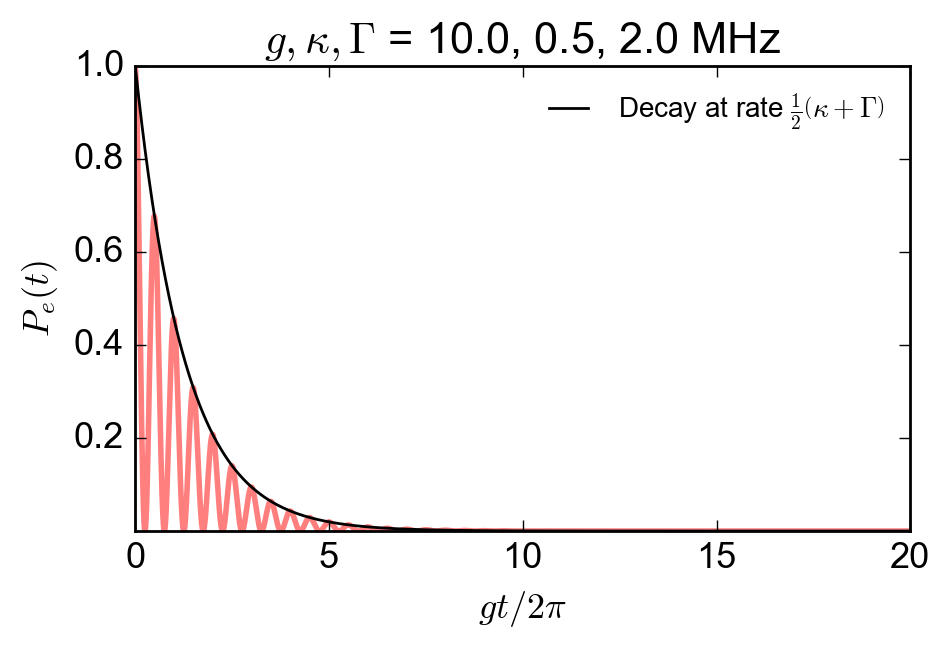

In [33]:
g = 2 * np.pi * 10E6
gamma = 2 * np.pi * 2E6
kappa = 2 * np.pi * 0.5E6
delta = 2 * np.pi * 0

t = np.linspace(0, 2 * np.pi / kappa, 1E4)

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)

plt.plot(g * t / (2*np.pi), np.abs(ce(t, g, gamma, kappa, delta))**2, '-r', lw=2, alpha=0.5)
plt.plot(g * t / (2*np.pi), 1 * np.exp(-(kappa+gamma)/2. * t), '-k', 
         label=r"Decay at rate $\frac{1}{2}\left(\kappa + \Gamma\right)$")
plt.ylim(1E-4, 1E0)
plt.ylabel("$P_e (t)$")
plt.xlabel("$g t/2\pi$")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.title("$g, \kappa, \Gamma$ = %.1f, %.1f, %.1f MHz" % \
          (g / (2*np.pi *1E6), kappa/(2*np.pi *1E6), gamma/(2 * np.pi * 1E6)))

## With some detuning

With detuning included the new decay rate becomes

$$\Gamma' = \frac{g^2}{\Delta^2} (\Gamma + \kappa)$$

Note that this is a lot slower than the case with no detuning. This makes sense, because with a large detuning, the Purcell effect can no longer enhance the decay of the qubit.

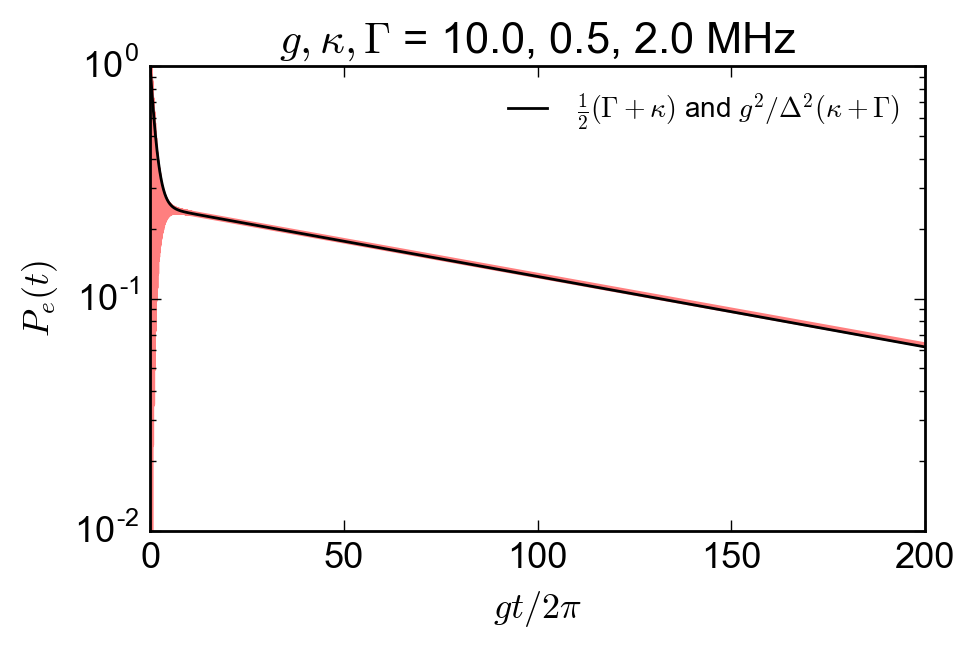

In [34]:
g = 2 * np.pi * 10E6
gamma = 2 * np.pi * 2.0E6
kappa = 2 * np.pi * 0.5E6
delta = 2 * np.pi * 150E6

t = np.linspace(0, 2 * np.pi * 10 / kappa, 1E4)

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)

plt.plot(g * t / (2*np.pi), np.abs(ce(t, g, gamma, kappa, delta))**2, '-r', lw=2, alpha=0.5)
plt.plot(g * t / (2*np.pi), 0.75 * np.exp(-(gamma + kappa)/2. * t) + \
         0.25 * np.exp(- g**2 / (delta**2) * (kappa + gamma) * t), '-k', 
         label=r"$\frac{1}{2}(\Gamma + \kappa)$ and $g^2/\Delta^2 (\kappa + \Gamma)$")
plt.yscale('log')
plt.ylim(1E-2, 1E0)
plt.xlim(np.min(g * t / (2 * np.pi)), np.max(g * t / (2 * np.pi)))
plt.ylabel("$P_e (t)$")
plt.xlabel("$g t/2\pi$")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.title("$g, \kappa, \Gamma$ = %.1f, %.1f, %.1f MHz" % \
          (g / (2*np.pi *1E6), kappa/(2*np.pi *1E6), gamma/(2 * np.pi * 1E6)))

# Limit 2: $g \ll \Gamma, \kappa$ (bad cavity limit)

The other very popular limit is the bad cavity limit where the linewidth of the cavity and the dephasing are much broader than the coupling. This is an unfavorable regime, since you're not able to observe any coherent information transfer between the two systems. In this limit, the decay rate of the qubit is given by

$$\Gamma' = $$

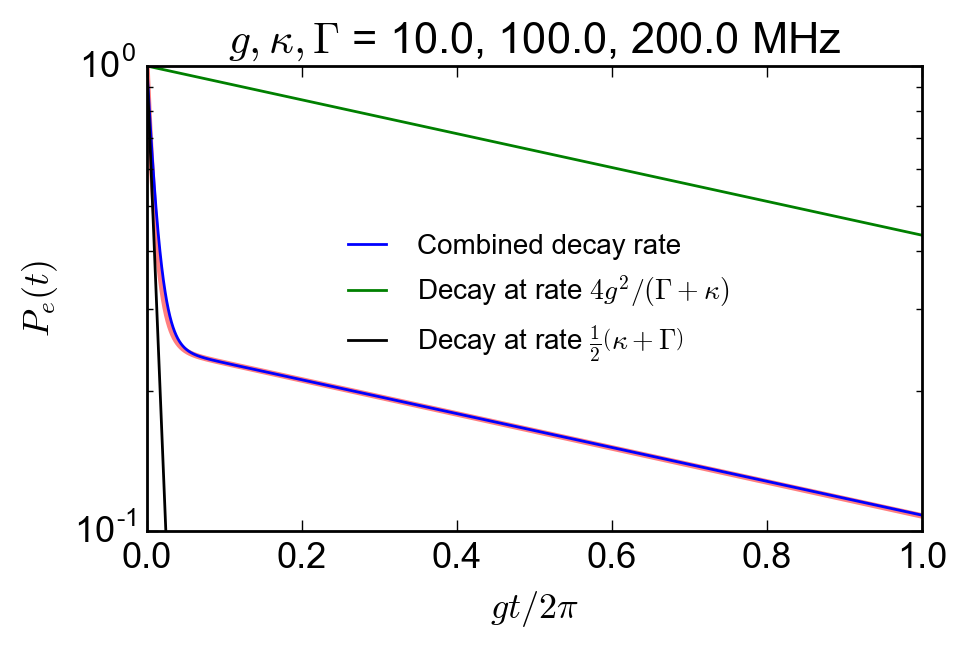

In [35]:
g = 2 * np.pi * 10E6
gamma = 2 * np.pi * 200E6
kappa = 2 * np.pi * 100E6
delta = 2 * np.pi * 0

t = np.linspace(0, 2 * np.pi / g, 1E4)

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)

plt.plot(g * t / (2*np.pi), np.abs(ce(t, g, gamma, kappa, delta))**2, '-r', lw=2, alpha=0.5)
plt.plot(g * t / (2*np.pi), 0.75 * np.exp(-(kappa+gamma)/2. * t) + 0.25*np.exp(- 4 * g**2/(kappa + gamma) * t), 
         label=r"Combined decay rate")
plt.plot(g * t / (2*np.pi), 1 * np.exp(- 4 * g**2/(gamma + kappa) * t), 
         label=r"Decay at rate $4 g^2/ (\Gamma + \kappa)$")
plt.plot(g * t / (2*np.pi), np.exp(-(kappa+gamma)/2. * t), '-k', 
         label=r"Decay at rate $\frac{1}{2}\left(\kappa + \Gamma\right)$")
plt.ylim(1E-1, 1E0)
plt.yscale('log')
plt.ylabel("$P_e (t)$")
plt.xlabel("$g t/2\pi$")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.title(r"$g, \kappa, \Gamma$ = %.1f, %.1f, %.1f MHz" % \
          (g / (2*np.pi *1E6), kappa/(2*np.pi *1E6), gamma/(2 * np.pi * 1E6)))

# Somewhere in between: $\Gamma > g > \kappa$

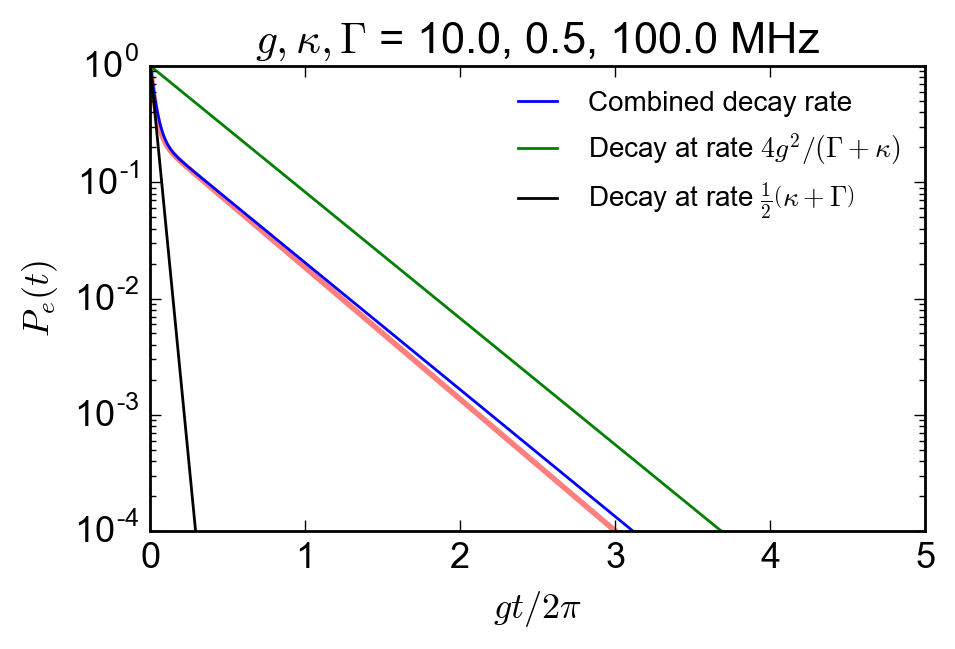

In [36]:
g = 2 * np.pi * 10E6
gamma = 2 * np.pi * 100E6
kappa = 2 * np.pi * 0.5E6
delta = 2 * np.pi * 0

t = np.linspace(0, 2 * np.pi * 5 / g, 1E4)

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)

plt.plot(g * t / (2*np.pi), np.abs(ce(t, g, gamma, kappa, delta))**2, '-r', lw=2, alpha=0.5)
plt.plot(g * t / (2*np.pi), 0.75 * np.exp(-(kappa + gamma)/2. * t) + 0.25*np.exp(- 4 * g**2/gamma * t), 
         label=r"Combined decay rate")
plt.plot(g * t / (2*np.pi), 1 * np.exp(- 4 * g**2/(gamma + kappa) * t), 
         label=r"Decay at rate $4 g^2/ (\Gamma + \kappa)$")
plt.plot(g * t / (2*np.pi), np.exp(-(kappa+gamma)/2. * t), '-k', 
         label=r"Decay at rate $\frac{1}{2}\left(\kappa + \Gamma\right)$")
plt.ylim(1E-4, 1E0)
plt.yscale('log')
plt.ylabel("$P_e (t)$")
plt.xlabel("$g t/2\pi$")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.title("$g, \kappa, \Gamma$ = %.1f, %.1f, %.1f MHz" % \
          (g / (2*np.pi *1E6), kappa/(2*np.pi *1E6), gamma/(2 * np.pi * 1E6)))

## With some detuning

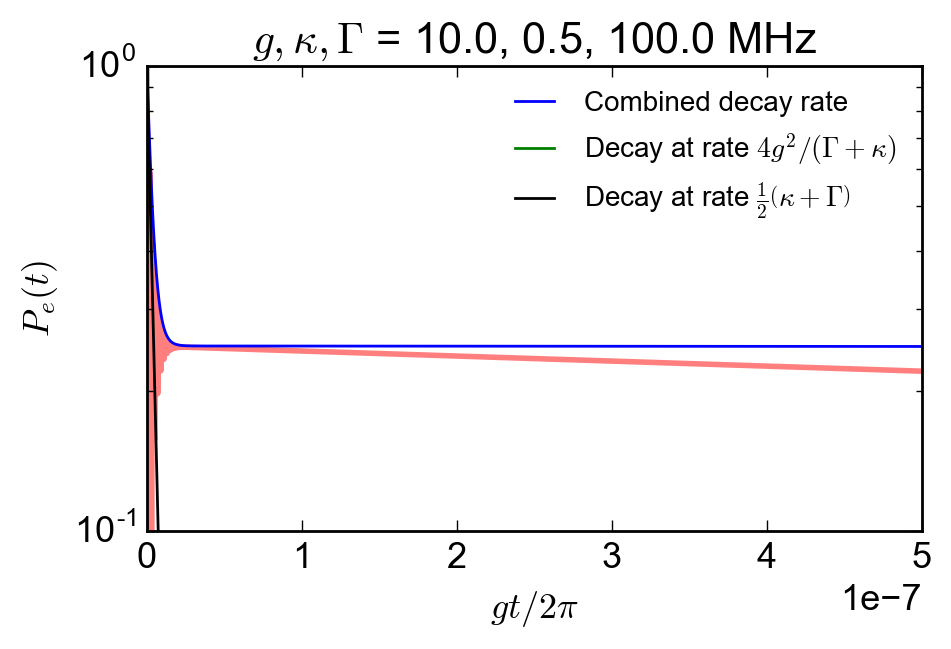

In [37]:
g = 2 * np.pi * 10E6
gamma = 2 * np.pi * 100E6
kappa = 2 * np.pi * 0.5E6
delta = 2 * np.pi * 500E6

t = np.linspace(0, 2 * np.pi * 5 / g, 1E4)

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)

plt.plot(t, np.abs(ce(t, g, gamma, kappa, delta))**2, '-r', lw=2, alpha=0.5)
plt.plot(t, 0.75 * np.exp(-(kappa + gamma)/2. * t) + 0.25*np.exp(- 4 * g**2/delta**2 * kappa * t), 
         label=r"Combined decay rate")
plt.plot(t, 1 * np.exp(-  g**2/(delta**2) * kappa * t), 
         label=r"Decay at rate $4 g^2/ (\Gamma + \kappa)$")
plt.plot(t, np.exp(-(kappa+gamma)/2. * t), '-k', 
         label=r"Decay at rate $\frac{1}{2}\left(\kappa + \Gamma\right)$")
plt.ylim(1E-1, 1E0)
plt.yscale('log')
plt.ylabel("$P_e (t)$")
plt.xlabel("$g t/2\pi$")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.title("$g, \kappa, \Gamma$ = %.1f, %.1f, %.1f MHz" % \
          (g / (2*np.pi *1E6), kappa/(2*np.pi *1E6), gamma/(2 * np.pi * 1E6)))